In [25]:
from datetime import datetime, timedelta
from itertools import product
import numpy as np
from scipy.stats import gmean
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt

## 2 Assets

In [86]:
def simulate_2_assets(r1, r2, std1, std2, rho, ef=False, rf_rate=0, title=None):
    # generate possible weights
    step_size = 0.01
    decimals = len(str(step_size).split('.')[1])
    possible_weights = np.arange(0, 1+step_size, step_size)
    
    # generate all possible weight combinations
    weight_combinations = list(product(possible_weights, repeat=2))
    
    # remove combinations that dont sum to 1
    weights = []
    for w in weight_combinations:
        w = np.round(w, decimals)
        if np.sum(w) == 1:
            weights.append(w)
        
    # for each weight combination, calculate expected return and standard deviation
    portfolios = {
        'weights': weights,
        'expected_returns': [],
        'standard_deviation': []
    }
    
    min_std = np.inf
    max_return = -np.inf

    for w in weights:
        exp_returns = w[0]*r1 + w[1]*r2
        std_returns = np.sqrt(w[0]**2*std1**2 + w[1]**2*std2**2 + 2*w[0]*w[1]*std1*std2*rho)
        
        if std_returns < min_std:
            min_std = std_returns
            min_std_return = exp_returns
        
        if exp_returns > max_return:
            max_return = exp_returns
            max_return_std = std_returns
        
        portfolios['expected_returns'].append(np.round(exp_returns, 4))
        portfolios['standard_deviation'].append(np.round(std_returns, 4))
    
    if ef:
        eff_front_r = [r for r in portfolios['expected_returns'] if r >= min_std_return]
        eff_front_std = [std for r, std in zip(portfolios['expected_returns'], portfolios['standard_deviation']) if r >= min_std_return]
        
    # capital market line
    if rf_rate > 0:
        v1 = r1 - rf_rate
        v2 = r2 - rf_rate       
        w1 = (v1*std2**2 - v2*rho*std1*std2) / (v1*std2**2 + v2*std1**2 - (v1+v2)*rho*std1*std2)
        w2 = 1 - w1
        
        tan_r = w1*r1 + w2*r2
        tan_std = np.sqrt(w1**2*std1**2 + w2**2*std2**2 + 2*w1*w2*std1*std2*rho)
        
        points = np.linspace(0, tan_std, 100)
        cml = [rf_rate + (tan_r - rf_rate) / tan_std * x for x in points]
        
    # Plot
    plt.figure(figsize=(8,6))
    if ef:
        plt.plot(eff_front_std, eff_front_r, color='m', label='Efficient Frontier', linestyle='--')
    if rf_rate > 0:
        plt.plot(points, cml, color='g', label='Capital Market Line')
        plt.scatter(tan_std, tan_r, color='g', marker='o', s=100, label='Tangency Portfolio')
    plt.scatter(portfolios['standard_deviation'], portfolios['expected_returns'], s=5)
    plt.scatter(min_std, min_std_return, color='r', marker='o', s=100, label=rf'Minimum $\sigma$ Portfolio')
    plt.scatter(max_return_std, max_return, color='y', marker='o', s=100, label=rf'Maximum $\mu$ Portfolio')
    plt.ylabel(rf'Expected Returns ($\mu$)')
    plt.xlabel(rf'Standard Deviation ($\sigma$)')
    if title:
        plt.title(title)
    else:
        plt.title(
            f'Expected Returns and Standard Deviations of Potential Portfolios \n'
            rf'Constructed from 2 Assets ($\rho$ = {rho}) with ($\mu_1$={r1}, $\sigma_1$={std1}) and ($\mu_2$={r2}, $\sigma_2$={std2})'
        )
    plt.legend()
    plt.show()

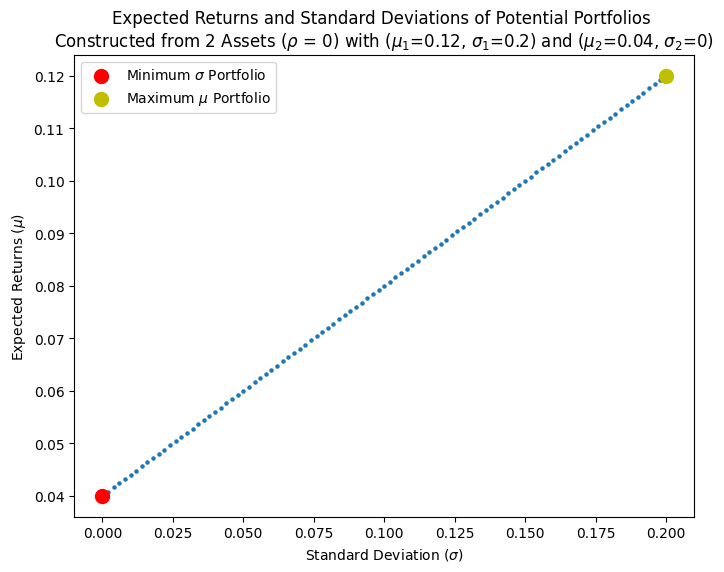

In [87]:
# 1 risky assets and 1 risk free asset
simulate_2_assets(0.12, 0.04, 0.2, 0, 0)

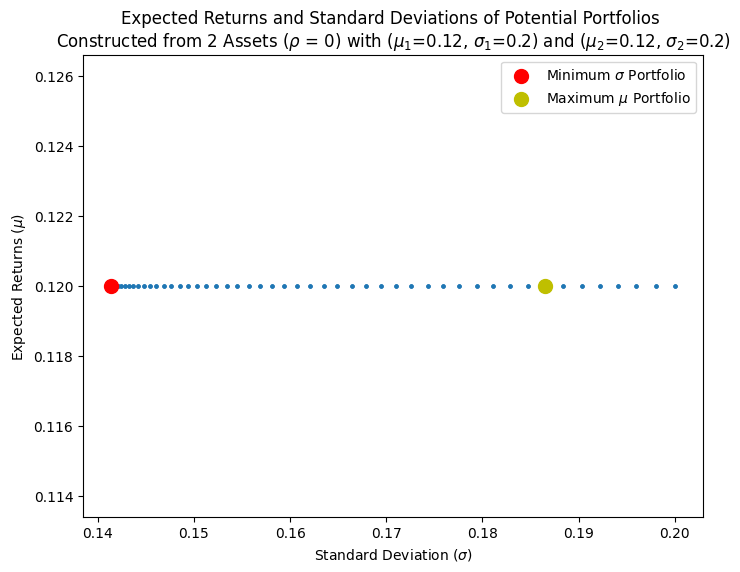

In [89]:
# 2 risky assets with equal returns and standard deviations but no correlation
simulate_2_assets(0.12, 0.12, 0.2, 0.2, 0)

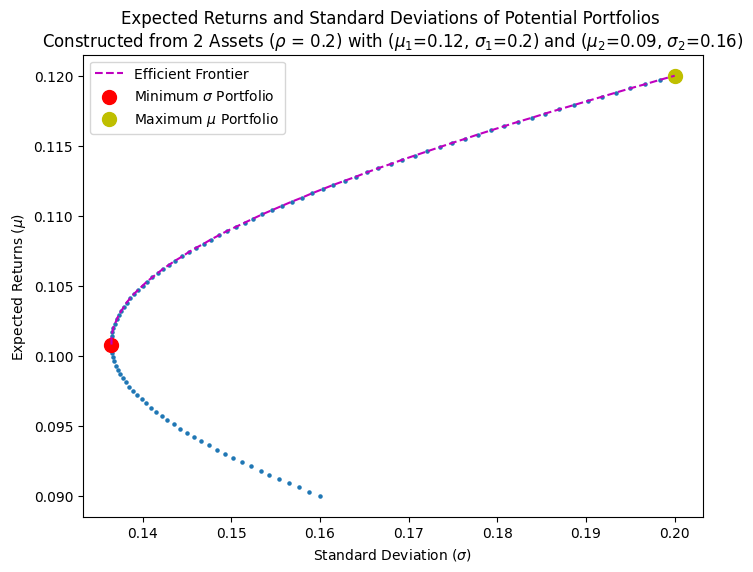

In [90]:
# 2 risky assets with different returns and standard deviations
simulate_2_assets(0.12, 0.09, 0.2, 0.16, 0.2, True)

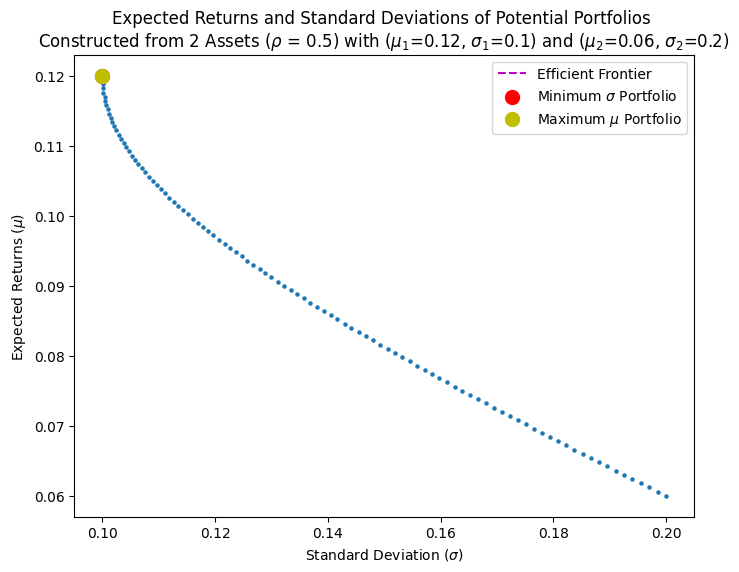

In [91]:
# 2 risky assets with one asset clearly better than the other
simulate_2_assets(0.12, 0.06, 0.1, 0.2, 0.5, True)

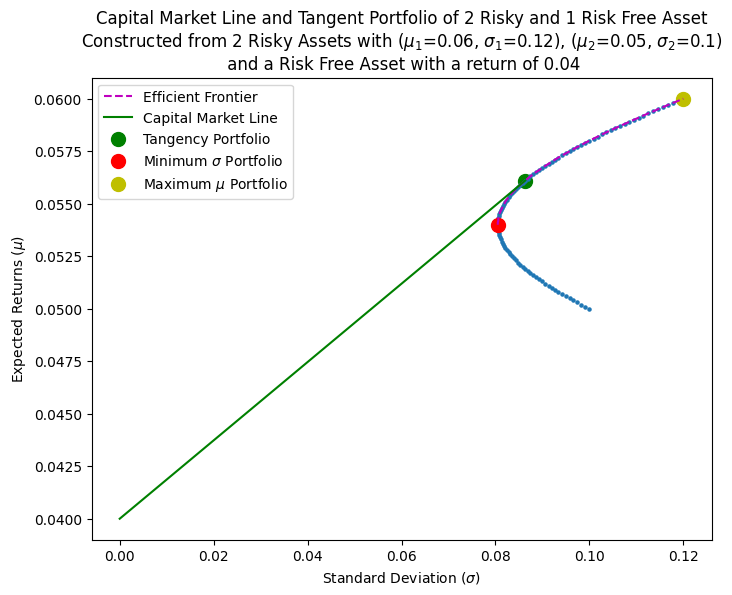

In [93]:
# tangent portfolio
risk_free_rate = 0.04
mu_1 = 0.06
mu_2 = 0.05
std_1 = 0.12
std_2 = 0.1

simulate_2_assets(
    mu_1, 
    mu_2, 
    std_1, 
    std_2, 
    0.1, 
    True, 
    risk_free_rate,
    (
        'Capital Market Line and Tangent Portfolio of 2 Risky and 1 Risk Free Asset\n'
        fr'Constructed from 2 Risky Assets with ($\mu_1$={mu_1}, $\sigma_1$={std_1}), ($\mu_2$={mu_2}, $\sigma_2$={std_2})'
        f'\n and a Risk Free Asset with a return of {risk_free_rate}'
     )
)

## n Assets

In [32]:
tickers = ['COST', 'MSFT', 'JPM', 'LLY', 'NKE']

start = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')
end = datetime.now().strftime('%Y-%m-%d')
interval = '1wk'

dfs = yf.download(tickers, start=start, end=end, interval=interval)

[*********************100%%**********************]  5 of 5 completed


In [33]:
# returns
weekly_returns = dfs['Adj Close'].pct_change().dropna()
average_weekly_returns = gmean(weekly_returns+1) - 1
annual_returns = (1 + average_weekly_returns)**52 - 1

# covatiance
weekly_cov = dfs['Adj Close'].pct_change().dropna().cov()
annual_cov = weekly_cov * 52

# define matrices
TICKERS = dfs['Adj Close'].columns
EXP_RETURNS = annual_returns
COV_MATRIX = annual_cov.to_numpy()
ONES = np.ones(len(TICKERS))

In [34]:
for i, ticker in enumerate(TICKERS):
    print(f'{ticker}:')
    print(f'Expected Return: {100*EXP_RETURNS[i]:.2f}%')
    print(f'{ticker} Standard Deviation: {100*np.sqrt(COV_MATRIX[i][i]):.2f}% \n')

COST:
Expected Return: 24.85%
COST Standard Deviation: 21.50% 

JPM:
Expected Return: 16.35%
JPM Standard Deviation: 26.28% 

LLY:
Expected Return: 32.81%
LLY Standard Deviation: 26.21% 

MSFT:
Expected Return: 28.54%
MSFT Standard Deviation: 23.63% 

NKE:
Expected Return: 10.63%
NKE Standard Deviation: 27.95% 



### Efficient Frontier
#### Weights of portfolios along Efficient Frontier ($\omega_{\mu_P}$) are defined by:

$$
\bold{\omega}_{\mu_p} = \bold{g} + \mu_P \bold{h} \quad (1)
$$

Where:

$$
\bold{g} = \frac{B}{D}\Omega^{-1}\bold{1} - \frac{A}{D}\Omega^{-1}\mu \quad (2)
$$

$$
\bold{h} = \frac{C}{D}\Omega^{-1}\mu - \frac{A}{D}\Omega^{-1}\bold{1} \quad (3)
$$

And:

$$
A = \mu^T \Omega^{-1} \bold{1} \quad (4)
$$

$$
B = \mu^T \Omega^{-1} \mu \quad (5)
$$

$$
C = \bold{1}^T \Omega^{-1} \bold{1} \quad (6)
$$

$$
D = BC-A^2 \quad (7)
$$

$\mu$ is the $1\text{x}n$ matrix of expected returns, **1** is a $1\text{x}n$ of 1s, and $\Omega^{-1}$ is the inverse of the $n\text{x}n$ Covariance Matrix of stocks...

In [35]:
cov_inv = np.linalg.inv(COV_MATRIX)

a = np.dot(ONES, np.dot(cov_inv, EXP_RETURNS))
b = np.dot(EXP_RETURNS, np.dot(cov_inv, EXP_RETURNS))
c = np.dot(ONES, np.dot(cov_inv, ONES))
d = b*c - a**2

g = b/d * np.dot(cov_inv, ONES) - a/d * np.dot(cov_inv, EXP_RETURNS)
h = c/d * np.dot(cov_inv, EXP_RETURNS) - a/d * np.dot(cov_inv, ONES)

# generate possible returns
mu_r = np.linspace(np.min(EXP_RETURNS), np.max(EXP_RETURNS)*1.2, 100)

# calculate weights
w_p = [g + mu * h for mu in mu_r]

# calculate standard deviation
std_r = [np.sqrt(np.dot(w, np.dot(COV_MATRIX, w))) for w in w_p]

### Minimum Variance Portfolio
#### Variance and Returns of minimum variance portfolio can be found by:

$$
\mu_{min} = -\frac{\bold{g}^T \Omega \bold{h}}{\bold{h}^T \Omega \bold{h}} \quad (8)
$$

$$
Var(R_{min}) = \bold{g}^T \Omega \bold{g} - \frac{(\bold{g}^T \Omega \bold{h})^2}{\bold{h}^T \Omega \bold{h}} \quad (9)
$$

In [36]:
mu_min = -np.dot(g, np.dot(COV_MATRIX, h)) / np.dot(h, np.dot(COV_MATRIX, h))
std_min = np.sqrt(np.dot(g, np.dot(COV_MATRIX, g)) - np.dot(g, np.dot(COV_MATRIX, h))**2 / np.dot(h, np.dot(COV_MATRIX, h)))

w_std_min = g + mu_min * h

In [37]:
print(f'Minimum Standard Deviation Portfolio:')
print(f'Expected Returns: {100*mu_min:.2f}%')
print(f'Standard Deviation: {100*std_min:.2f}%')
print(f'Weights:')
for t, w in zip(TICKERS, w_std_min):
    print(f'{t}: {100*w:.2f}%')

Minimum Standard Deviation Portfolio:
Expected Returns: 24.75%
Standard Deviation: 16.87%
Weights:
COST: 32.62%
JPM: 17.31%
LLY: 24.15%
MSFT: 17.47%
NKE: 8.45%


In [38]:
# efficient frontier
mu_eff = [r for r in mu_r if r >= mu_min]
std_eff = [std for r, std in zip(mu_r, std_r) if r >= mu_min]
w_eff = [w for r, w in zip(mu_r, w_p) if r >= mu_min]

In [39]:
# calculate a bunch of possible portfolios
step_size = 0.1
decimals = len(str(step_size).split('.')[1])
possible_weights = np.arange(0, 1+step_size, step_size)

# generate all possible weight combinations
weight_combinations = list(product(possible_weights, repeat=len(TICKERS)))

# remove combinations that dont sum to 1
weights = []
for w in weight_combinations:
    w = np.round(w, decimals)
    if np.sum(w) == 1:
        weights.append(w)
        
# for each weight combination, calculate expected return and standard deviation
portfolios = {
    'weights': weights,
    'expected_returns': [],
    'standard_deviation': []
}

for w in weights:
    exp_returns = np.dot(w, annual_returns)
    std_returns = np.sqrt(np.dot(w, np.dot(COV_MATRIX, w)))

    portfolios['expected_returns'].append(np.round(exp_returns, 4))
    portfolios['standard_deviation'].append(np.round(std_returns, 4))

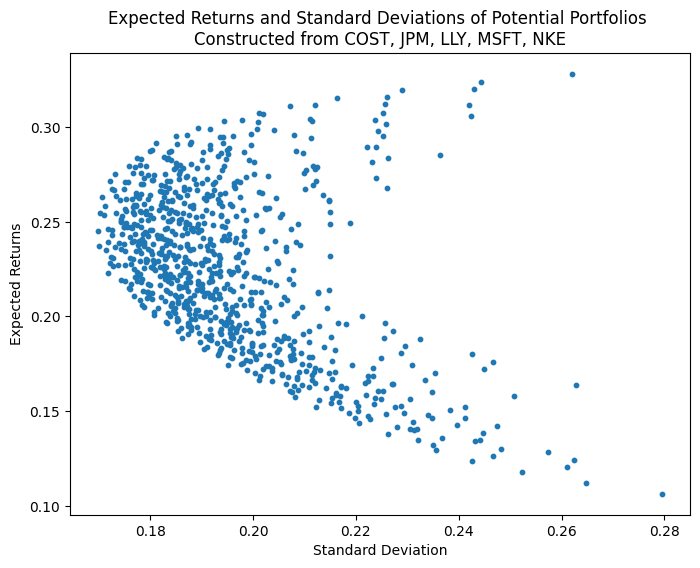

In [40]:
# Plot
plt.figure(figsize=(8,6))
plt.scatter(portfolios['standard_deviation'], portfolios['expected_returns'], s=10)
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.show()

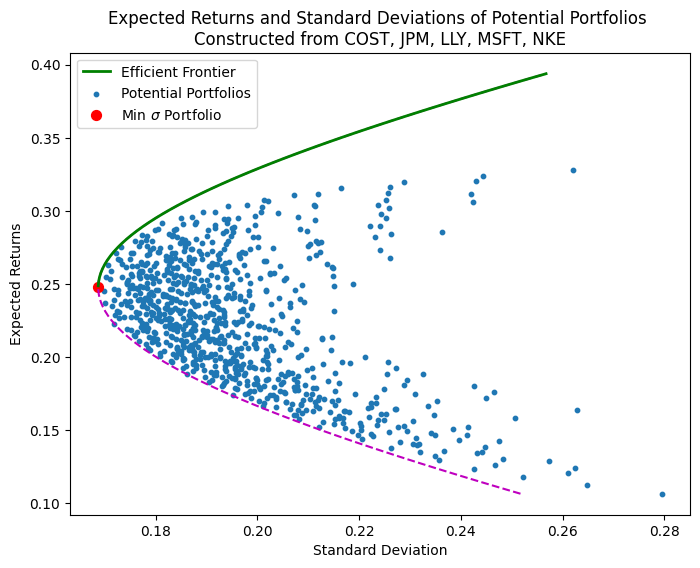

In [41]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_r, mu_r, color='m', linestyle='--')
plt.plot(std_eff, mu_eff, color='g', label='Efficient Frontier', linestyle='-', linewidth=2.0)
plt.scatter(portfolios['standard_deviation'], portfolios['expected_returns'], s=10, label='Potential Portfolios')
plt.scatter(std_min, mu_min, color='r', marker='o', s=50, label=rf'Min $\sigma$ Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

In [42]:
# point along efficient frontier
w_point = g + 0.35 * h
print(rf'weights of portfolio on efficient frontier ($\mu=0.35$):')
for t, w in zip(TICKERS, w_point):
    print(f'{t}: {100*w:.2f}%')

weights of portfolio on efficient frontier ($\mu=0.35$):
COST: 39.78%
JPM: -0.49%
LLY: 46.07%
MSFT: 47.58%
NKE: -32.94%


### Tangent Portfolio
#### Weights of the tangent portfolio can be found by:

$$
\omega_T = \frac{\bar{\omega}}{\bold{1}^T \bar{\omega}} \quad (10)
$$

Where:

$$
\bar{\omega} = \Omega^{-1} (\mu-\mu_f \bold{1}) \quad (11)
$$

$(\mu-\mu_f \bold{1})$ is also known as the excess returns. It measures how much returns we can get by taking on risk.

In [43]:
mu_f = 0.0425
mu_ex = EXP_RETURNS - mu_f
w_bar = np.dot(cov_inv, (mu_ex * ONES))
w_t = w_bar / np.dot(ONES, w_bar)

mu_t = np.dot(EXP_RETURNS, w_t)
std_t = np.sqrt(np.dot(w_t, np.dot(COV_MATRIX, w_t)))

In [44]:
# tangent portfolio
print(f'Tangent Portfolio constructed with {", ".join(TICKERS)}:')
print(f'Expected Returns: {100*mu_t:.2f}%')
print(f'Standard Deviation: {100*std_t:.2f}%')
print('Weights:')
for t, w in zip(TICKERS, w_t):
    print(f'{t}: {100*w:.2f}%')

Tangent Portfolio constructed with COST, JPM, LLY, MSFT, NKE:
Expected Returns: 32.68%
Standard Deviation: 19.87%
Weights:
COST: 38.16%
JPM: 3.54%
LLY: 41.11%
MSFT: 40.76%
NKE: -23.57%


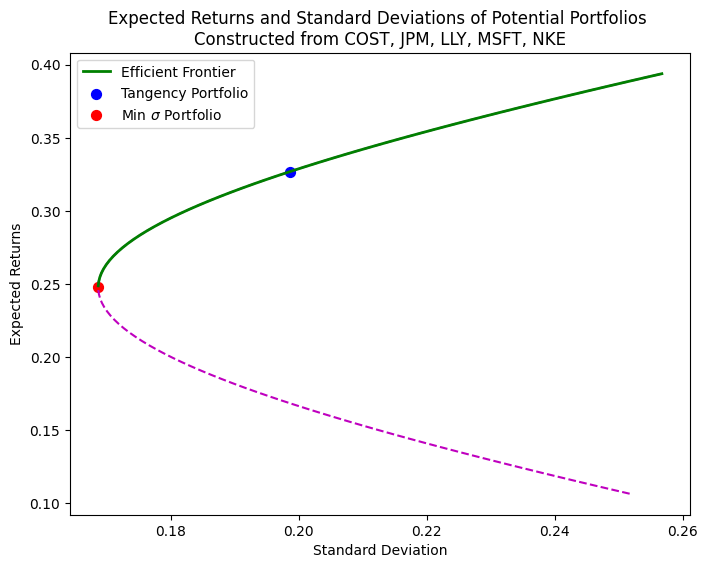

In [45]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_r, mu_r, color='m', linestyle='--')
plt.plot(std_eff, mu_eff, color='g', label='Efficient Frontier', linestyle='-', linewidth=2.0)
plt.scatter(std_t, mu_t, color='b', marker='o', s=50, label='Tangency Portfolio')
plt.scatter(std_min, mu_min, color='r', marker='o', s=50, label=rf'Min $\sigma$ Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

### Capital Market Line

This problem now becomes a 1 risky asset (the tangent portfolio) and 1 risk free asset question. To figure out the best portfolio for a desired return, we can just figure out the weights of each asset...

Sharpe's ratio can be found using:

$$
c_p = \frac{\mu_p - \mu_f}{(\mu-\mu_f \bold{1})^T \Omega^{-1} (\mu-\mu_f \bold{1})} \quad (12)
$$

where $\mu_p$ is the expected return of the portfolio, and $\mu_f$ is the risk free rate of return.

We can then use $c_p(\bold{1}^T \bar{\omega})$ to determine how much weight we should put on the tangent portfolio to achieve the desired $\mu_p$

The standard deviation for the desired expected return can be found using:

$$
\sigma_p = \sqrt{c_p^2\bar{\omega} \Omega \bar{\omega}^T} \enspace (13)
$$

In [60]:
# generate possible returns
mu_p = np.linspace(mu_f, mu_t, 100)

c_p = (mu_p - mu_f) / (np.dot(mu_ex, np.dot(cov_inv, mu_ex)))
std_p = [np.sqrt(c**2 * np.dot(w_bar, np.dot(COV_MATRIX, w_bar))) for c in c_p]

In [61]:
# ex: 80-20 split
mu_80_20 = 0.8 * mu_t + 0.2 * mu_f
c_p_80_20 = (mu_80_20 - mu_f) / (np.dot(mu_ex, np.dot(cov_inv, mu_ex)))
std_80_20 = np.sqrt(c_p_80_20**2 * np.dot(w_bar, np.dot(COV_MATRIX, w_bar)))

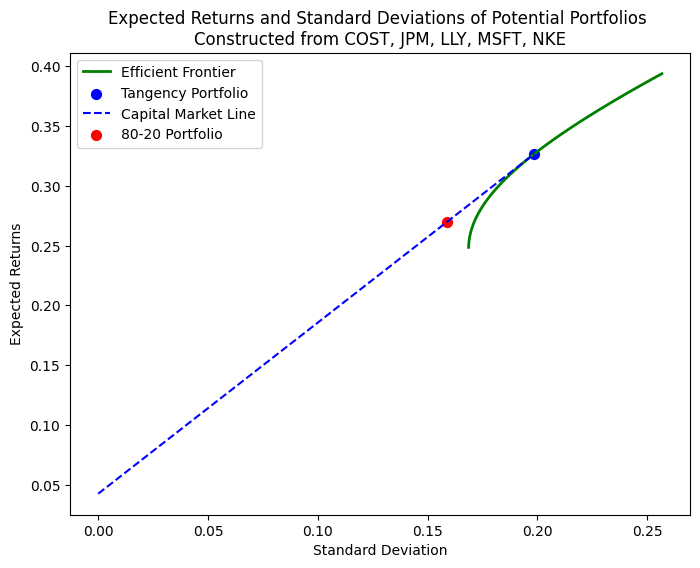

In [63]:
# Plot
plt.figure(figsize=(8,6))
plt.plot(std_eff, mu_eff, color='g', label='Efficient Frontier', linestyle='-', linewidth=2.0)
plt.scatter(std_t, mu_t, color='b', marker='o', s=50, label='Tangency Portfolio')
plt.plot(std_p, mu_p, color='b', label='Capital Market Line', linestyle='--')
plt.scatter(std_80_20, mu_80_20, color='r', marker='o', s=50, label='80-20 Portfolio')
plt.ylabel('Expected Returns')
plt.xlabel('Standard Deviation')
plt.title(
    f'Expected Returns and Standard Deviations of Potential Portfolios \n'
    f'Constructed from {", ".join(TICKERS)}'
)
plt.legend()
plt.show()

In [64]:
print(f'80-20 portfolio:')
print(f'Expected Returns: {100*mu_80_20:.2f}%')
print(f'Standard Deviation: {100*std_80_20:.2f}%')

80-20 portfolio:
Expected Returns: 26.99%
Standard Deviation: 15.89%
